In [8]:
# Install necessary libraries
!pip install transformers datasets torch scikit-learn

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset


In [1]:
! pip install --upgrade datasets


In [2]:
from datasets import load_dataset

# Load a smaller slice of the dataset directly
paws = load_dataset("paws", "labeled_final", split="train[:10000]")

# Then proceed with extracting fields
small_texts1 = list(paws['sentence1'])
small_texts2 = list(paws['sentence2'])
small_labels = list(paws['label'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.79k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/8.43M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/49401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [9]:
paws = load_dataset("paws", "labeled_final", split="train")

#Sample smaller subset for faster training ---
small_texts1 = list(paws['sentence1'])[:10000]
small_texts2 = list(paws['sentence2'])[:10000]
small_labels = list(paws['label'])[:10000]
from sklearn.model_selection import train_test_split

# --- Train/Validation Split ---
train_texts1, val_texts1, train_texts2, val_texts2, train_labels, val_labels = train_test_split(
    small_texts1, small_texts2, small_labels, test_size=0.2, random_state=42)


In [10]:
class PawsDataset(Dataset):
    def __init__(self, sentence1, sentence2, labels, tokenizer, max_length=128):  # max_length updated
        self.sentence1 = sentence1
        self.sentence2 = sentence2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text1 = self.sentence1[idx]
        text2 = self.sentence2[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text1, text2,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [11]:
# --- Set Hyperparameters ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 5  # More epochs
batch_size = 16
learning_rate = 2e-5

# --- Initialize Tokenizer, Dataset, Dataloader ---
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = PawsDataset(train_texts1, train_texts2, train_labels, tokenizer)
val_dataset = PawsDataset(val_texts1, val_texts2, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
class SupConModel(nn.Module):
    def __init__(self, pretrained_model='distilbert-base-uncased', projection_dim=128, num_classes=2):
        super(SupConModel, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(0.1)
        self.projector = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, return_projection=False):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        pooled_output = self.dropout(pooled_output)

        if return_projection:
            projected = self.projector(pooled_output)
            projected = F.normalize(projected, dim=1)  # L2-normalize embeddings
            return projected.unsqueeze(1)  # Shape: [batch_size, 1, projection_dim]

        logits = self.classifier(pooled_output)
        return logits



In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all', base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        device = features.device
        if len(features.shape) < 3:
            raise ValueError("`features` needs to be [bsz, n_views, ...]")
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError("Cannot define both `labels` and `mask`")
        if labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        if labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError("`labels` shape does not match `features` shape")
            mask = torch.eq(labels, labels.T).float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        anchor_feature = contrast_feature
        anchor_count = contrast_count

        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )

        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        mask = mask.repeat(anchor_count, contrast_count)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)

        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)

        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss


In [14]:
# --- Initialize Model ---
model = SupConModel().to(device)
contrastive_loss_fn = SupConLoss()
classification_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)  # Scheduler added
epochs=5
# --- Training Loop ---
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        features = model(input_ids, attention_mask, return_projection=True)
        logits = model(input_ids, attention_mask, return_projection=False)

        loss_c = contrastive_loss_fn(features, labels)
        loss_cls = classification_loss_fn(logits, labels)

        loss = loss_c + loss_cls

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Step the scheduler

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Training Epoch 1: 100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


Epoch [1/5], Loss: 3.4062


Training Epoch 2: 100%|██████████| 500/500 [02:43<00:00,  3.05it/s]


Epoch [2/5], Loss: 3.3730


Training Epoch 3: 100%|██████████| 500/500 [02:43<00:00,  3.05it/s]


Epoch [3/5], Loss: 3.2615


Training Epoch 4: 100%|██████████| 500/500 [02:43<00:00,  3.05it/s]


Epoch [4/5], Loss: 2.9849


Training Epoch 5: 100%|██████████| 500/500 [02:43<00:00,  3.06it/s]

Epoch [5/5], Loss: 2.7665


In [16]:
# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.29it/s]

Validation Accuracy: 71.95%


In [17]:
from sklearn.metrics import classification_report

# Collect all true and predicted labels
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validation for Report"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Generate classification report
report = classification_report(true_labels, pred_labels, digits=4)
print("Classification Report:\n")
print(report)


Validation for Report: 100%|██████████| 125/125 [00:07<00:00, 17.30it/s]

Classification Report:

              precision    recall  f1-score   support

           0     0.7642    0.7079    0.7350      1099
           1     0.6731    0.7336    0.7021       901

    accuracy                         0.7195      2000
   macro avg     0.7187    0.7208    0.7185      2000
weighted avg     0.7232    0.7195    0.7202      2000



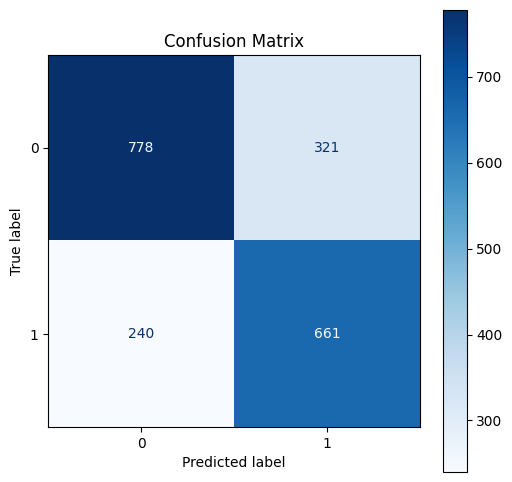

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()
